In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.exposure import rescale_intensity
from imutils import build_montages
from imutils import paths
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [6]:
#prepare net for face detection
prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [7]:
inputPath='caltech_faces'
imagePaths = list(paths.list_images(inputPath))
print(imagePaths)

['caltech_faces\\abraham\\image_0022.jpg', 'caltech_faces\\abraham\\image_0023.jpg', 'caltech_faces\\abraham\\image_0024.jpg', 'caltech_faces\\abraham\\image_0025.jpg', 'caltech_faces\\abraham\\image_0026.jpg', 'caltech_faces\\abraham\\image_0027.jpg', 'caltech_faces\\abraham\\image_0028.jpg', 'caltech_faces\\abraham\\image_0029.jpg', 'caltech_faces\\abraham\\image_0030.jpg', 'caltech_faces\\abraham\\image_0031.jpg', 'caltech_faces\\abraham\\image_0032.jpg', 'caltech_faces\\abraham\\image_0033.jpg', 'caltech_faces\\abraham\\image_0034.jpg', 'caltech_faces\\abraham\\image_0035.jpg', 'caltech_faces\\abraham\\image_0036.jpg', 'caltech_faces\\abraham\\image_0037.jpg', 'caltech_faces\\abraham\\image_0038.jpg', 'caltech_faces\\abraham\\image_0039.jpg', 'caltech_faces\\abraham\\image_0040.jpg', 'caltech_faces\\abraham\\image_0041.jpg', 'caltech_faces\\alberta\\image_0166.jpg', 'caltech_faces\\alberta\\image_0167.jpg', 'caltech_faces\\alberta\\image_0168.jpg', 'caltech_faces\\alberta\\image_01

In [10]:
names = [p.split(os.path.sep)[-2] for p in imagePaths]
print(names)

['abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'abraham', 'alberta', 'alberta', 'alberta', 'alberta', 'alberta', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'allen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'carmen', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'conrad', 'cynthia', 'cynthia', 'cynthia', 

In [13]:
(names, counts) = np.unique(names, return_counts=True)
print(counts)
print(names)


[20  5 29 20 23 20 21 19 21  5 20 22 21 20  5 21  5 21  5 22 22  5 21 20
 25  7]
['abraham' 'alberta' 'allen' 'carmen' 'conrad' 'cynthia' 'darrell' 'flyod'
 'frank' 'glen' 'gloria' 'jacques' 'judy' 'julie' 'kathleen' 'kenneth'
 'lewis' 'mae' 'phil' 'raymond' 'rick' 'ronald' 'sherry' 'tiffany'
 'willie' 'winston']


In [16]:
names = names.tolist()
print(names)

['abraham', 'alberta', 'allen', 'carmen', 'conrad', 'cynthia', 'darrell', 'flyod', 'frank', 'glen', 'gloria', 'jacques', 'judy', 'julie', 'kathleen', 'kenneth', 'lewis', 'mae', 'phil', 'raymond', 'rick', 'ronald', 'sherry', 'tiffany', 'willie', 'winston']


In [17]:
#initialize two list to save faces and labels(name of person)
faces = []
labels = []

In [18]:
for imagePath in imagePaths:
        # load the image from disk and extract the name of the person
        # from the subdirectory structure
    image = cv2.imread(imagePath)
    name = imagePath.split(os.path.sep)[-2]

        # only process images that have a sufficient number of
        # examples belonging to the class
    if counts[names.index(name)] < 6:
        continue

        # perform face detection
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

    # pass the blob through the network to obtain the face detections,
    # then initialize a list to store the predicted bounding boxes
    net.setInput(blob)
    detections = net.forward()
    boxes = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.7:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # update our bounding box results list
            boxes.append((startX, startY, endX, endY))
    

        # loop over the faces
    for (startX, startY, endX, endY) in boxes:
        # extract the face ROI, resize it, and convert it to
        # grayscale
        faceROI = image[startY:endY, startX:endX]
        faceROI = cv2.resize(faceROI, (47, 62))
        faceROI = cv2.cvtColor(faceROI, cv2.COLOR_BGR2GRAY)

        # update our faces and labels lists
        faces.append(faceROI)
        labels.append(name)

In [19]:
faces = np.array(faces)
labels = np.array(labels)


In [20]:
print("[INFO] {} images in dataset".format(len(faces)))

[INFO] 416 images in dataset


In [21]:
# flatten all 2D faces into a 1D list of pixel intensities
pcaFaces = np.array([f.flatten() for f in faces])

In [24]:
print(pcaFaces)
print(np.shape(pcaFaces))

[[109 117 104 ... 192 185 126]
 [ 80  96  80 ... 111 119 117]
 [ 75  66  74 ... 128 115  77]
 ...
 [ 36  33  37 ...  95  22  62]
 [ 52  30  55 ...  88   4  46]
 [ 27  44  39 ...  62  53  81]]
(416, 2914)


In [25]:
# encode the string labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

In [26]:
print(labels)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15

In [27]:
split = train_test_split(faces, pcaFaces, labels, test_size=0.25,stratify=labels, random_state=42)
(origTrain, origTest, trainX, testX, trainY, testY) = split

In [30]:
print(np.shape(origTrain))
print(np.shape(origTest))
print(np.shape(trainX))
print(np.shape(testX))
print(np.shape(trainY))
print(np.shape(testY))

(312, 62, 47)
(104, 62, 47)
(312, 2914)
(104, 2914)
(312,)
(104,)


In [31]:
pca = PCA(svd_solver="randomized",n_components=150,whiten=True)
start = time.time()
trainX = pca.fit_transform(trainX)
end = time.time()
print("[INFO] computing eigenfaces took {:.4f} seconds".format(end - start))

[INFO] computing eigenfaces took 0.2432 seconds


In [33]:
images = []

    # loop over the first 16 individual components
for (i, component) in enumerate(pca.components_[:16]):
	# reshape the component to a 2D matrix, then convert the data
# type to an unsigned 8-bit integer so it can be displayed
		# with OpenCV
    component = component.reshape((62, 47))
    component = rescale_intensity(component, out_range=(0, 255))
    component = np.dstack([component.astype("uint8")] * 3)
    images.append(component)

	# construct the montage for the images
montage = build_montages(images, (47, 62), (4, 4))[0]

	# show the mean and principal component visualizations
	# show the mean image
mean = pca.mean_.reshape((62, 47))
mean = rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
cv2.imshow("Mean", mean)
cv2.imshow("Components", montage)
cv2.waitKey(0)

-1

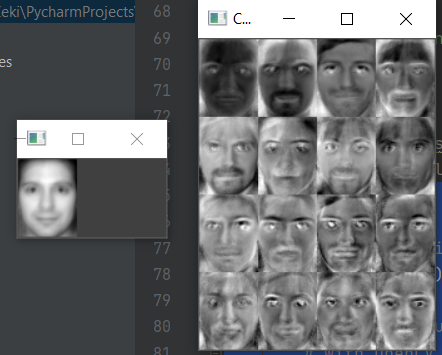

In [34]:
# train a classifier on the eigenfaces representation
print("[INFO] training classifier...")
model = SVC(kernel="rbf", C=10.0, gamma=0.001, random_state=42)
model.fit(trainX, trainY)

[INFO] training classifier...


SVC(C=10.0, gamma=0.001, random_state=42)

In [35]:
# evaluate the model
print("[INFO] evaluating model...")
predictions = model.predict(pca.transform(testX))
print(classification_report(testY, predictions,target_names=le.classes_))

[INFO] evaluating model...
              precision    recall  f1-score   support

     abraham       1.00      1.00      1.00         5
       allen       0.88      1.00      0.93         7
      carmen       1.00      1.00      1.00         5
      conrad       1.00      1.00      1.00         6
     cynthia       1.00      0.80      0.89         5
     darrell       1.00      1.00      1.00         5
       flyod       0.83      1.00      0.91         5
       frank       0.83      1.00      0.91         5
      gloria       1.00      1.00      1.00         5
     jacques       1.00      0.83      0.91         6
        judy       1.00      1.00      1.00         5
       julie       1.00      1.00      1.00         5
     kenneth       1.00      1.00      1.00         5
         mae       1.00      1.00      1.00         5
     raymond       1.00      1.00      1.00         6
        rick       1.00      1.00      1.00         5
      sherry       1.00      0.83      0.91         6


In [36]:
idxs = np.random.choice(range(0, len(testY)), size=10, replace=False)
print(idxs)

[ 71  64  88  61  91  96   5  29  28 102]


In [40]:
for i in idxs:
    # grab the predicted name and actual name
    predName = le.inverse_transform([predictions[i]])[0]
    actualName = le.classes_[testY[i]]

    # grab the face image and resize it such that we can easily see
    # it on our screen
    face = np.dstack([origTest[i]] * 3)
    face = imutils.resize(face, width=250)

    # draw the predicted name and actual name on the image
    cv2.putText(face, "pred: {}".format(predName), (5, 25),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2.putText(face, "actual: {}".format(actualName), (5, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # display the predicted name, actual name, and confidence of the
    # prediction (i.e., chi-squared distance; the *lower* the distance
    # is the *more confident* the prediction is)
    print("[INFO] prediction: {}, actual: {}".format(predName, actualName))

    # display the current face to our screen
    cv2.imshow("Face", face)
    cv2.waitKey(0)

[INFO] prediction: willie, actual: willie
[INFO] prediction: flyod, actual: flyod
[INFO] prediction: darrell, actual: darrell
[INFO] prediction: conrad, actual: conrad
[INFO] prediction: kenneth, actual: kenneth
[INFO] prediction: allen, actual: allen
[INFO] prediction: raymond, actual: raymond
[INFO] prediction: julie, actual: julie
[INFO] prediction: raymond, actual: raymond
[INFO] prediction: raymond, actual: raymond


REFERENCE LINKS: 
* https://pyimagesearch.com/2021/05/10/opencv-eigenfaces-for-face-recognition/

* https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf

* https://en.wikipedia.org/wiki/Principal_component_analysis